<a href="https://colab.research.google.com/github/LuisRCrtr/data_science_portfolio/blob/main/Heart_atack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
!apt-get update 

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop2.7.tgz

!tar xf spark-3.2.2-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop2.7"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [902 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

In [ ]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import findspark
findspark.init()

In [ ]:
# Initializing a Spark session
from pyspark.sql import SparkSession

from pyspark.sql import SQLContext

spark = SparkSession.builder.appName('hearth').getOrCreate()

sqlContext = SQLContext(spark)

/content/spark-3.2.2-bin-hadoop2.7/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
spark

# Introduction 


Task: to perform EDA and predict if a person is prone to a heart attack or not.



About this dataset:

*   Age : Age of the patient
*   Sex : Sex of the patient
*   exang: exercise induced angina (1 = yes; 0 = no)
*   ca: number of major vessels (0-3)
*   cp : Chest Pain type chest pain type:
*   trtbps : resting blood pressure (in mm Hg)
*   chol : cholestoral in mg/dl fetched via BMI sensor
*   fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
*   rest_ecg : resting electrocardiographic results
*   target : 0= less chance of heart attack 1= more chance of heart attack


# Packages 

In [ ]:
import pandas as pd
import sys
sys.path.insert(0, "/lib/")
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StandardScaler, ChiSqSelector
from pyspark.sql.types import * 
from pyspark.sql.functions import isnull, when, count, col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import udf
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Reading The Dataset  

In [ ]:
df = spark.read.csv("heart.csv", header=True, inferSchema=True)

df.show(5)

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|    2|     1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|    2|     1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|    2|     1|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trtbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalachh: integer (nullable = true)
 |-- exng: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slp: integer (nullable = true)
 |-- caa: integer (nullable = true)
 |-- thall: integer (nullable = true)
 |-- output: integer (nullable = true)



In [ ]:
df = df.withColumnRenamed("output","label")
df.show(5)

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|label|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|    1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|    1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|    2|    1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|    2|    1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|    2|    1|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
only showing top 5 rows



In [ ]:
# Dataframe shape 
df.count(), len(df.columns)

(303, 14)

In [ ]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|                cp|            trtbps|              chol|                fbs|          restecg|          thalachh|               exng|           oldpeak|               slp|               caa|             thall|             label|
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               303|                303|               303|               303|               303|                303|              303|               303|    

In [ ]:
df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  165|
|    0|  138|
+-----+-----+



In [ ]:
# Checking the number of unique values in each column

from pyspark.sql.functions import col, countDistinct

df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|label|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
| 41|  2|  4|    49| 152|  2|      3|      91|   2|     40|  3|  5|    4|    2|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+



In [ ]:
# Missing values

from pyspark.sql.functions import isnull, when, count, col

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|label|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+
|  0|  0|  0|     0|   0|  0|      0|       0|   0|      0|  0|  0|    0|    0|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+-----+



There are no NaN values in the data.

#  EDA

In [ ]:
pnd = df.toPandas()

Number of people having less chance of heart attack are 138 and Number of people having  more chance of heart attack are 165


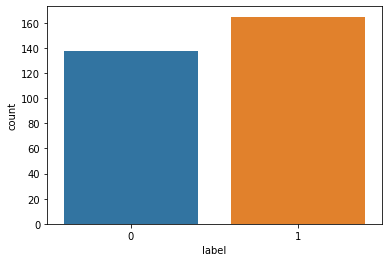

In [ ]:
x=(pnd.label.value_counts())
print = print(f'Number of people having less chance of heart attack are {x[0]} and Number of people having  more chance of heart attack are {x[1]}')
p = sns.countplot(data=pnd, x="label")
plt.show()

Number of people having sex as 1 are 96 and Number of people having sex as 0 are 207


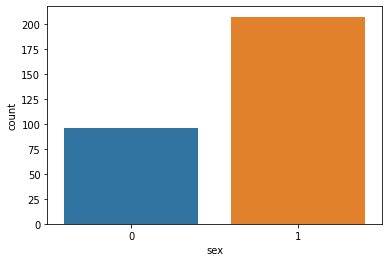

In [ ]:
x=(pnd.sex.value_counts())
print(f'Number of people having sex as 0 are {x[0]} and Number of people having sex as 1 are {x[1]}')
p = sns.countplot(data=pnd, x="sex")
plt.show()

0    143
2     87
1     50
3     23
Name: cp, dtype: int64


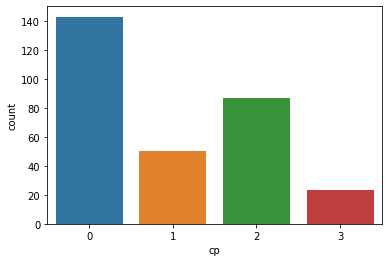

In [ ]:
# Chest pain type

x=(pnd.cp.value_counts())
print(x)
p = sns.countplot(data=pnd, x="cp")
plt.show()

It can be observed people have chest pain of type 0 i.e 'Typical Angina' is the highest.

1    152
0    147
2      4
Name: restecg, dtype: int64


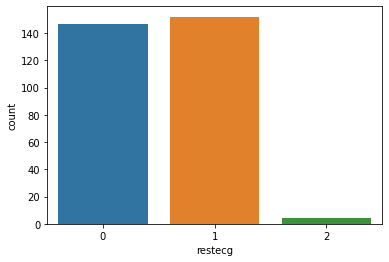

In [ ]:
x=(pnd.restecg.value_counts())
print(x)
p = sns.countplot(data=pnd, x="restecg")
plt.show()

EGC count  for type 2 its almost negligible in comparision to type 0 and 1.

2    166
3    117
1     18
0      2
Name: thall, dtype: int64


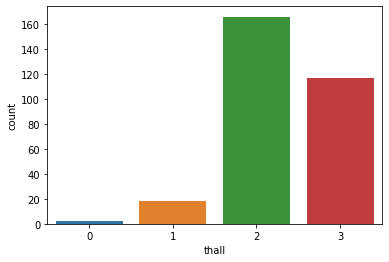

In [ ]:
x=(pnd.thall.value_counts())
print(x)
p = sns.countplot(data=pnd, x="thall")
plt.show()

Thall count is max for type 2 and min for type 0.

0    258
1     45
Name: fbs, dtype: int64


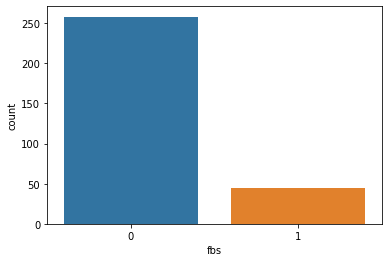

In [ ]:
x=(pnd.fbs.value_counts())
print(x)
p = sns.countplot(data=pnd, x="fbs")
plt.show()

fbs count is more than double for type 0

0    204
1     99
Name: exng, dtype: int64


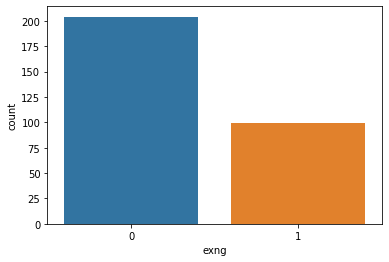

In [ ]:
x=(pnd.exng.value_counts())
print(x)
p = sns.countplot(data=pnd, x="exng")
plt.show()

EXNG count is more than double for type 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Your Charts are being ready:   0%|          | 0/5 [00:00<?, ?it/s]

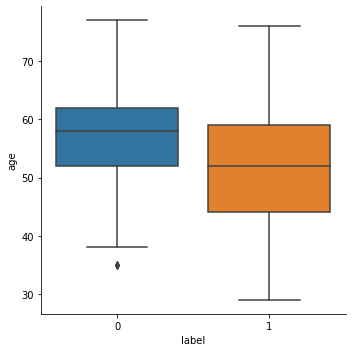

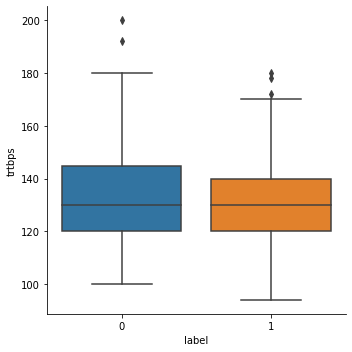

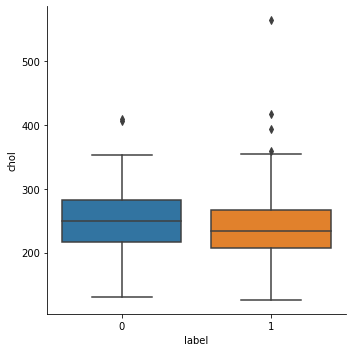

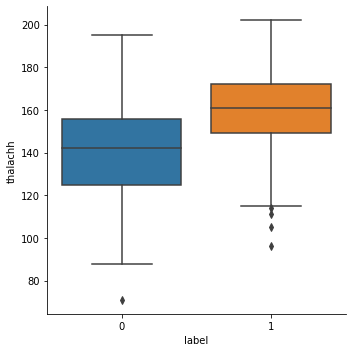

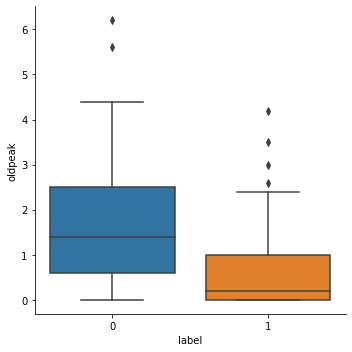

In [ ]:
def box_plotter(pnd, columnName):
    """
    Plots boxplots for column given as parameter.
    """
    sns.catplot(x="label", y=columnName, data=pnd, kind="box");
for column in tqdm_notebook(num_cols, desc = "Your Charts are being ready"):
    box_plotter(pnd, column)

There are certain outliers in all the continuous features

<Figure size 720x720 with 0 Axes>

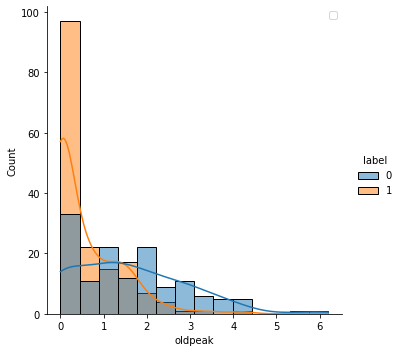

In [ ]:
# Distribution of continuous features according to target variable

plt.figure(figsize=(10,10))
sns.displot(pnd, x="oldpeak", hue="label", kde= True)
plt.legend()


<Figure size 720x720 with 0 Axes>

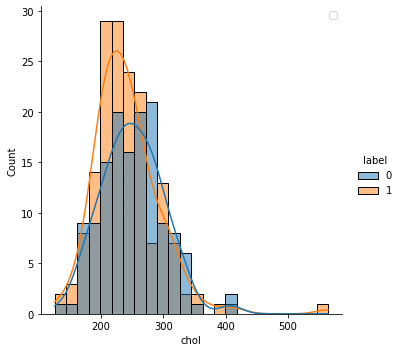

In [ ]:
num_cols = ["age","trtbps","chol","thalachh","oldpeak"]

plt.figure(figsize=(10,10))
sns.displot(pnd,x="chol", hue="label", kde= True)
plt.legend()

<Figure size 720x720 with 0 Axes>

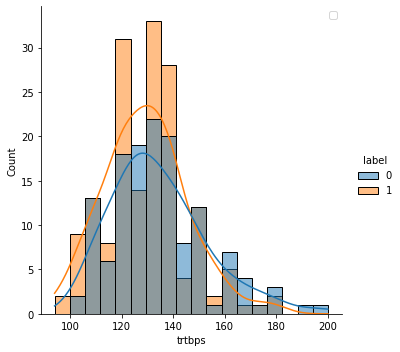

In [ ]:
num_cols = ["age","trtbps","chol","thalachh","oldpeak"]

plt.figure(figsize=(10,10))
sns.displot(pnd, x = "trtbps", hue="label", kde= True)
plt.legend()

<Figure size 720x720 with 0 Axes>

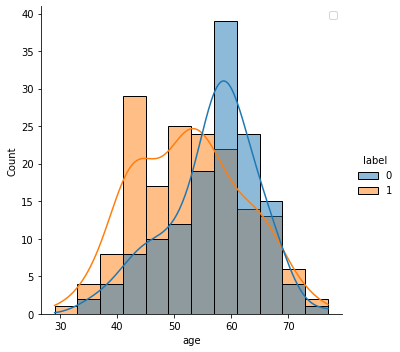

In [ ]:
num_cols = ["age","trtbps","chol","thalachh","oldpeak"]

plt.figure(figsize=(10,10))
sns.displot(data = pnd,x = "age", color="green",hue="label", kde= True)
plt.legend()

<Figure size 720x720 with 0 Axes>

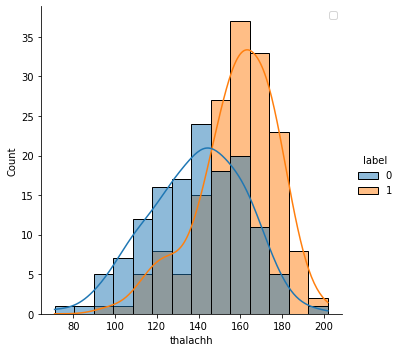

In [ ]:
plt.figure(figsize=(10,10))
sns.displot(pnd, x="thalachh", hue="label", kde= True)
plt.legend()

# Bivariate Analysis

In [ ]:
df_corr = pnd[num_cols].corr().transpose()
df_corr

,age,trtbps,chol,thalachh,oldpeak
age,1.000000,0.279351,0.213678,-0.398522,0.210013
trtbps,0.279351,1.000000,0.123174,-0.046698,0.193216
chol,0.213678,0.123174,1.000000,-0.009940,0.053952
thalachh,-0.398522,-0.046698,-0.009940,1.000000,-0.344187
oldpeak,0.210013,0.193216,0.053952,-0.344187,1.000000


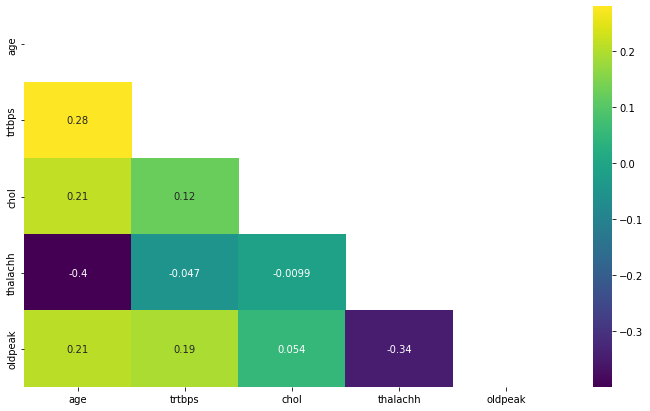

In [ ]:
# Scatter Matrix

plt.figure(figsize=(12,7))
mask = np.triu(np.ones_like(df_corr))
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
sns.heatmap(df_corr,annot=True,mask=mask,cmap='viridis')

There is no apparent linear correlation between continuous variable according to the heatmap.

<Figure size 864x864 with 0 Axes>

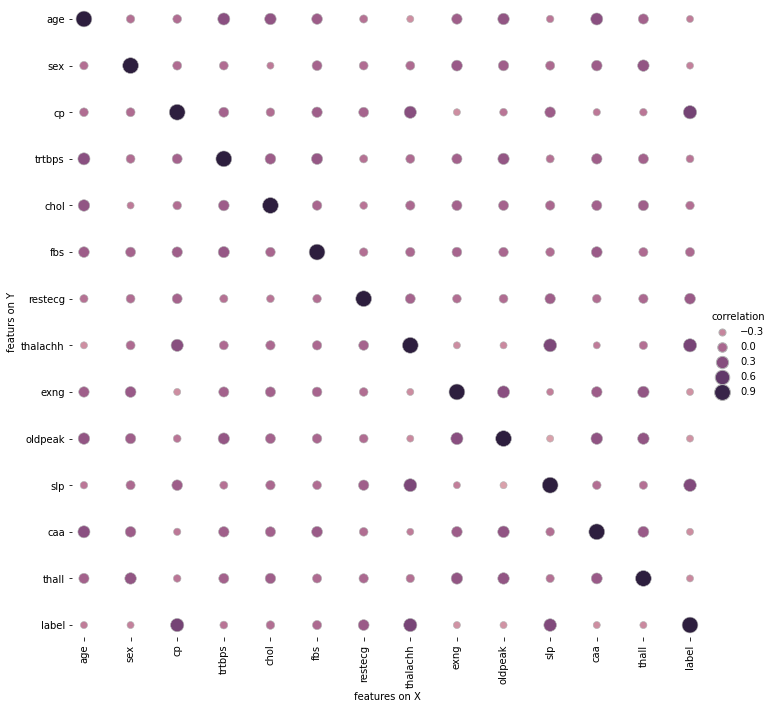

In [ ]:
# Scatterplot heatmap of dataframe

fig = plt.figure(figsize=(12,12))
corr_mat = pnd.corr().stack().reset_index(name="correlation")
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)
g.set(xlabel="features on X", ylabel="featurs on Y", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.show()

The scatterplot heatmap matrix suggests that there might be some correlation between output and cp, thalachh and slp

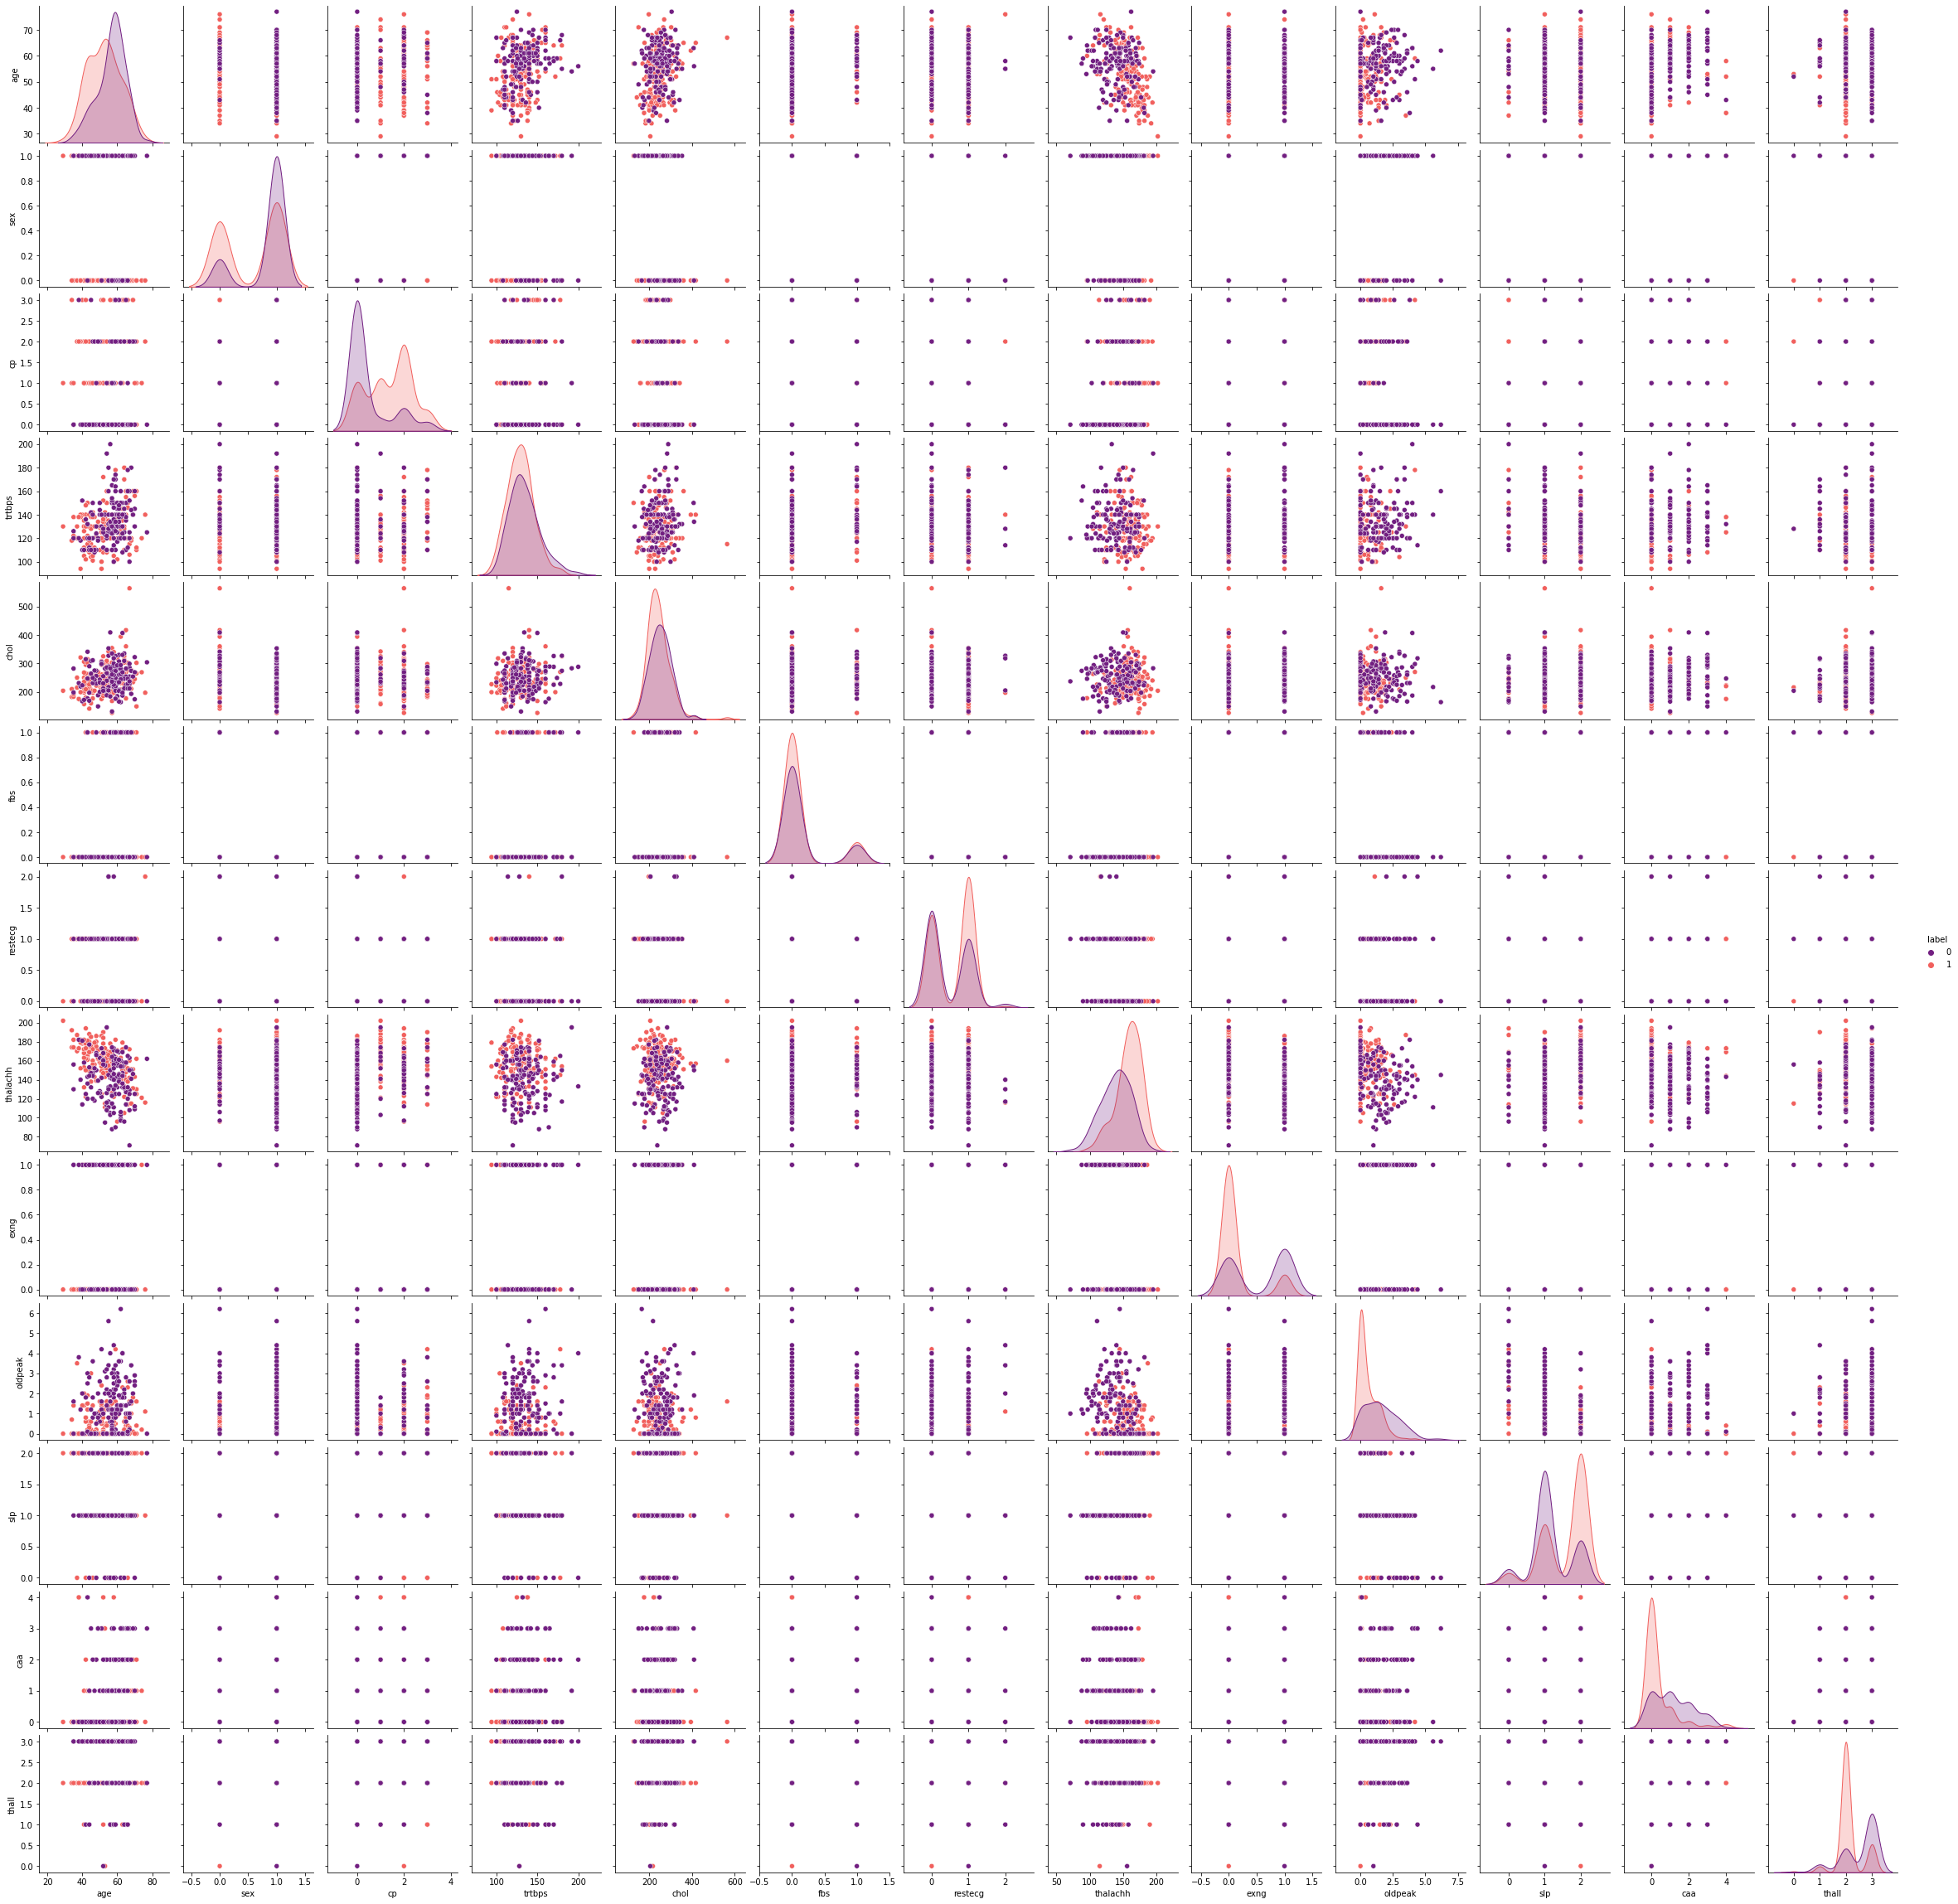

In [ ]:
# Pairplot

sns.pairplot(pnd, hue="label", palette="magma")

# Data preprocessing

In [ ]:
cat_cols = cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
num_cols = ["age","trtbps","chol","thalachh","oldpeak"]

In [ ]:
# one hot encode categorical columns to numerical vector columns
encoder = OneHotEncoder(inputCols=cat_cols,
                        outputCols=['sex1', 'exng1', 'caa1', 'cp1', 'fbs1', 'restecg1', 'slp1', 'thall1'],
                        handleInvalid='keep')

In [ ]:
# transform numerical columns to a single vector column
num_assembler = VectorAssembler(inputCols=num_cols, 
                                outputCol='num_features')

In [ ]:
# apply scaler (MinMax scaler preserves original data distribution)
scaler = StandardScaler(inputCol="num_features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [ ]:
# transform all create vector columns into one vector column
assembler = VectorAssembler(inputCols=["scaledFeatures", 'sex1', 'exng1', 'caa1', 'cp1', 'fbs1', 'restecg1', 'slp1', 'thall1'], \
                            outputCol='total_features')

In [ ]:
# Feature selection using chisquareSelector

css = ChiSqSelector(featuresCol='total_features',
                    outputCol='features',
                    labelCol='label',
                    fpr=0.6)

In [ ]:
# create pipeline with above steps
data_pipeline = Pipeline(stages=[encoder, num_assembler, 
                                 scaler,assembler, css])

In [ ]:
# fit pipeline and transform dataframe
df_pip = data_pipeline.fit(df).transform(df)

In [ ]:
# split data into train, validation and test sets
train, validation_test = df_pip.randomSplit([0.7, 0.3], seed = 4)
validation, test = validation_test.randomSplit([0.5, 0.5], seed = 4)

# Modeling

In [ ]:
# Training the model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20, seed=42)
rf_model = rf.fit(train)

In [ ]:
#Predictions

predictions = rf_model.transform(test)
predictions.select("label","rawPrediction","prediction",
                    "probability").show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    1|[1.35959422957191...|       1.0|[0.06797971147859...|
|    1|[0.94837111998471...|       1.0|[0.04741855599923...|
|    1|[2.08430939183003...|       1.0|[0.10421546959150...|
|    1|[8.73042213627007...|       1.0|[0.43652110681350...|
|    1|[7.53956071139169...|       1.0|[0.37697803556958...|
|    1|[1.29939993508959...|       1.0|[0.06496999675447...|
|    0|[12.6169841157029...|       0.0|[0.63084920578514...|
|    1|[0.82425764480740...|       1.0|[0.04121288224037...|
|    1|[4.34091827195978...|       1.0|[0.21704591359798...|
|    1|[3.00269245247506...|       1.0|[0.15013462262375...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
        # predict on validation set
validation_prediction = model.transform(validation)
 
    # use MulticlassClassificationEvaluator to get f1 scores
evaluator1 = MulticlassClassificationEvaluator(labelCol='label')
 
    # use BinaryClassificationEvaluator to get area under PR 
evaluator2 = BinaryClassificationEvaluator(
    rawPredictionCol='prediction', labelCol='label')
    
    # make evaluation and print f1 and area under PR score per model

evaluator1.evaluate(validation_prediction, {evaluator1.metricName:'f1'})
    


0.9121808143547274

In [ ]:
evaluator2.evaluate(validation_prediction,{evaluator2.metricName:'areaUnderPR'})



0.8908184796490644

# Conclusion



*   F1 score for random forest model on validation set: 0.9121808143547274
*   Area under PR for Random Forest on validation set: 0.8908184796490644


